In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xbbg import blp
from IPython.core.display import display, HTML
import mplfinance as mpf 
import multitasking
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
data = blp.bdh(
    tickers='MAIL RX Curncy', flds=['Open', 'High', 'Low', 'last_price'],
    start_date='2018', Per='D', Fill='P', Days='A',
)
data = data[data.columns[0][0]].rename({'last_price':'Close'}, axis=1)
data.index = data.index.rename('timestamp')
data['Adj'] = data['Close']
data1 = data.dropna()

In [28]:
data.append(  blp.bdib(ticker='CO1 Comdty', dt=('2021-04-'+str(i))))

CO1 Comdty                                       \
                                open   high    low  close volume num_trds   
2021-04-05 01:01:00+01:00      64.63  64.65  64.63  64.63      9        9   
2021-04-05 01:02:00+01:00      64.61  64.61  64.61  64.61      3        3   
2021-04-05 01:03:00+01:00      64.60  64.60  64.59  64.59      4        4   
2021-04-05 01:04:00+01:00      64.59  64.59  64.59  64.59      2        2   
2021-04-05 01:05:00+01:00      64.60  64.62  64.60  64.61     23        8   
...                              ...    ...    ...    ...    ...      ...   
2021-04-05 22:53:00+01:00      62.30  62.30  62.30  62.30      1        1   
2021-04-05 22:56:00+01:00      62.30  62.30  62.30  62.30      1        1   
2021-04-05 22:57:00+01:00      62.30  62.30  62.30  62.30      1        1   
2021-04-05 22:58:00+01:00      62.23  62.30  62.23  62.30      4        4   
2021-04-05 22:59:00+01:00      64.57  64.81  64.57  64.81     75       20   

                                    
                             value  
2021-04-05 01:01:00+01:00   581.70  
2021-04-05 01:02:00+01:00   193.83  
2021-04-05 01:03:00+01:00   258.39  
2021-04-05 01:04:00+01:00   129.18  
2021-04-05 01:05:00+01:00  1485.91  
...                            ...  
2021-04-05 22:53:00+01:00    62.30  
2021-04-05 22:56:00+01:00    62.30  
2021-04-05 22:57:00+01:00    62.30  
2021-04-05 22:58:00+01:00   249.03  
2021-04-05 22:59:00+01:00  4845.91  

[1249 rows x 7 columns]

In [29]:
data

""


In [54]:
data = pd.DataFrame()
for i in range(1, 16):
    data = data.append(blp.bdib(ticker='CO1 Comdty', dt=('2021-04-'+str(i))))
data.index = [data.index[j].tz_localize(None) for j in range(data.shape[0]) ] 
data = data[data.columns[0][0]].rename({'open':'Open', 'close':'Close', 'low':'Low', 'high':'High'}, axis=1)
data['Adj'] = (data.Open + data.Close + data.Low + data.High)/4

In [498]:
data = blp.bdh(
    tickers='YNDX RX Index', flds=['Open', 'High', 'Low', 'last_price'],
    start_date='2018', Per='D', Fill='P', Days='A',
)
data = data[data.columns[0][0]].rename({'last_price':'Close'}, axis=1)
data.index = data.index.rename('timestamp')
data['Adj'] = data['Close']
data2 = data.dropna()

In [499]:
data = pd.merge(data1, data2, left_index=True, right_index=True)

In [536]:
data['Adj'] = -data['Adj_x'] + data['Adj_y'] 
data['Close'] = -data['Close_x'] + data['Close_y'] 
data['High'] = -data['High_x'] + data['High_y'] 
data['Low'] = -data['Low_x'] + data['Low_y'] 
data['Open'] = -data['Open_x'] + data['Open_y'] 

In [558]:
data.to_csv('forMe.csv')

In [55]:
class MA(object):
    def __init__(self, df, args):
        sma_span = args[0]
        ema_span = args[1]
        df['sma'+str(args[0])] = df['Adj'].rolling(sma_span).mean()
        df['ema'+str(args[1])] = df['Adj'].ewm(span=ema_span).mean()
        self.args = ['sma'+str(args[0]), 'ema'+str(args[1])]
        self.df = df
        
    def signal_for_buy(self):
        df = self.df        
        return np.where(df[self.args[1]] > df[self.args[0]], 1, 0)
    
    def signal_for_sell(self):
        df = self.df
        return np.zeros(df.shape[0])

class MR(object):
    def __init__(self, df, args):
        sma_span = args[0]
        ema_span = args[1]
        df['smaH'+str(args[0])] = df['High'].rolling(sma_span).mean()
        df['smaL'+str(args[0])] = df['Low'].rolling(sma_span).mean()
        df['emaP'+str(args[1])] = df['Adj'].ewm(span=ema_span).mean()      
        self.offset = args[2]
        self.args = ['smaH'+str(args[0]), 'smaL'+str(args[0]), 'emaP'+str(args[1])]
        self.df = df
        
    def signal_for_buy(self):
        df = self.df        
        return np.where(df[self.args[2]] > df[self.args[0]]*(1+self.offset), 1, 0)
    
    def signal_for_sell(self):
        df = self.df
        return np.where(df[self.args[2]] < df[self.args[1]]*(1-self.offset), -1, 0)
    
class Backtest(object):
    """
    Data format is {'Open', 'High', 'Low', 'Close', 'Adj'}, index.name = 'Timestamp'
    """
    def __getitem__(self, name):
        return self._df[name]          
    
    @property
    def df(self):
        return self._df

    @df.setter
    def df(self, value):
        try:
            assert isinstance(value, pd.core.frame.DataFrame)
        except AssertionError:
            print('Value must be DataFrame')
            return
        self._df = value
        
    @df.deleter
    def df(self):
        del self._df
        
        
    def __init__(self):
        self.args = 0
        
    def call_MA(self, *args):
        if(len(args) > 2):
            print("Too many args for MA")
            pass
            
        self.MA = MA((self.df).copy(), args)
        self.arg = len(args) 
        
    def call_MR(self, *args):
        if(len(args) > 3):
            print("Too many args for MA")
            pass
            
        self.MR = MR((self.df).copy(), args)
        self.arg = len(args) 

    def run(self, Strategy):
        df = self.df
        long_positions = eval('self.'+Strategy).signal_for_buy()
        short_positions = eval('self.'+Strategy).signal_for_sell()
        df['Position'] = long_positions+short_positions
        buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)
        
        dates = np.arange(len(df))
        price = df['Adj']
        arg = []
        for i in range(len(eval('self.'+Strategy).args)):
            arg.append((eval('self.'+Strategy).args)[i])
            
            
        def reindex_signals(signals, markers):
            '''
            takes two pd.Series (boolean, float) and returns signals and markers reindexed to an integer range, and their index
            '''
            signals.reset_index(drop=True, inplace=True)
            signals = signals[signals==True]
            dates = signals.index
            markers = markers[dates]
            markers.index = dates
            return signals, markers, dates

        buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) != 1)
        buy_marker = df.Adj * buy_signals - (df.Adj.max()*.04)
        buy_signals, buy_marker, buy_dates = reindex_signals(buy_signals, buy_marker)
       
    
        exit_buy_signals = (df['Position'] != 1) & (df['Position'].shift(1) == 1)
        exit_buy_marker = df.Adj * exit_buy_signals + (df.Adj.max()*.04)
        exit_buy_signals, exit_buy_marker, exit_buy_dates = reindex_signals(exit_buy_signals, exit_buy_marker)

        sell_signals = (df['Position'] == -1) & (df['Position'].shift(1) != -1)
        sell_marker = df.Adj  * sell_signals + (df.Adj .max()*.04)
        sell_signals, sell_marker, sell_dates = reindex_signals(sell_signals, sell_marker)

        exit_sell_signals = (df['Position'] != -1) & (df['Position'].shift(1) == -1)
        exit_sell_marker = df.Adj  * exit_sell_signals - (df.Adj .max()*.04)
        exit_sell_signals, exit_sell_marker, exit_sell_dates = reindex_signals(exit_sell_signals, exit_sell_marker)

        with plt.style.context('fivethirtyeight'):
            fig = plt.figure(figsize=(14,7))
            ax = plt.subplot(1,1,1)
            mpf.plot(df, ax=ax, show_nontrading=False, type='candle')
            for i in range(len(eval('self.'+Strategy).args)):
                plt.plot(dates, eval('self.'+Strategy).df[arg[i]], linewidth=2, label=str(eval('self.'+Strategy).args[i]))
            
            ax.scatter(buy_dates, buy_marker, marker='^', color='green', s=160, label='Buy')
            ax.scatter(exit_buy_dates, exit_buy_marker, marker='v', s=160, label='Exit Buy')
            ax.scatter(sell_dates, sell_marker, marker='v', color='red', s=160, label='Sell')
            ax.scatter(exit_sell_dates, exit_sell_marker, marker='^', color='orange', s=160, label='Exit Sell')
            plt.title(Strategy)
            ax.set_ylabel('Price($)')
            plt.legend()
            
        plt.show()
        
        
        df['Hold'] = np.log(df['Adj'] / df['Adj'].shift(1))
        df['Strategy'] = df['Position'].shift(1) * df['Hold']
        returns = np.exp(df[['Hold', 'Strategy']].sum()) - 1
        print(f"Buy and hold return: {round(returns['Hold']*100,2)}%")
        print(f"Strategy return: {round(returns['Strategy']*100,2)}%")
        

In [67]:
ex = Backtest()
ex.df = data[-500::]

<ipython-input-55-f62b9d11d417>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'] = long_positions+short_positions


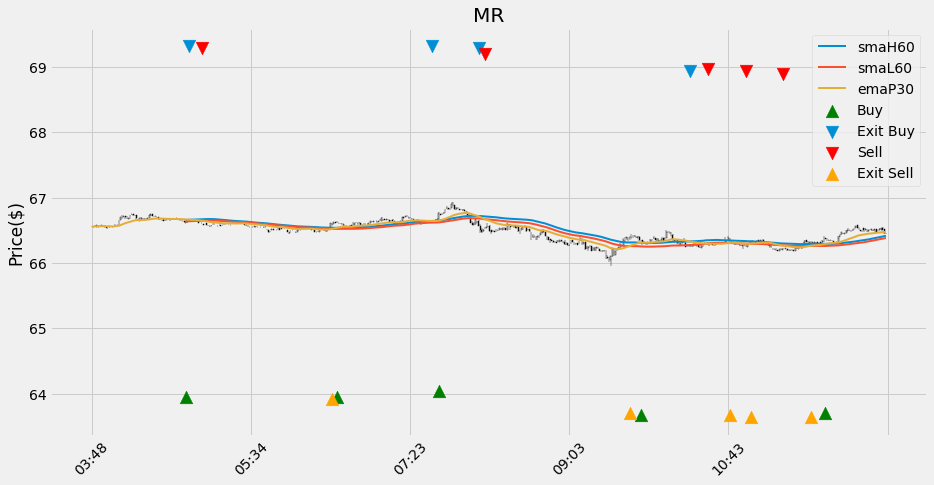

Buy and hold return: -0.16%
Strategy return: -0.22%


<ipython-input-55-f62b9d11d417>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hold'] = np.log(df['Adj'] / df['Adj'].shift(1))
<ipython-input-55-f62b9d11d417>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy'] = df['Position'].shift(1) * df['Hold']


In [71]:
ex.call_MR(60, 30, 0)
ex.run('MR')

In [556]:
def foo(*aaa):
    print(*aaa)

In [557]:
foo(1, 2, 3)

1 2 3
